In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io
import sys
sys.path.append('../j2')

from quality import compute_overlap_array, bounding_box
from graphing import plot_volume
from util import remove_labels, overlay_images, calculate_stats
from skimage.measure import label
from IPython import display

In [2]:
annotation = io.imread('../data/annotation.tiff')
probmap_1 = io.imread('../data/probmap_span_1.tiff')
#probmap_2 = io.imread('../data/probmap_span_2.tiff')

In [3]:
z, y, x = (0, 16), (0, 179), (179, 359)

In [4]:
probmap_subsection = probmap_1[z[0]:z[1], y[0]:y[1], x[0]:x[1]]
annotation_subsection = annotation[z[0]:z[1], y[0]:y[1], x[0]:x[1]]

In [5]:
thresholds = np.arange(0.5, 1.0, 0.05)
overlaps = []

for threshold in thresholds:
    labels = label(probmap_subsection >= threshold)
    labels = remove_labels(labels, 1)
    overlaps.append(compute_overlap_array(labels, annotation_subsection))

In [18]:
def plot_graph_performance(overlaps, x_range, threshold):
    fig, ax = plt.subplots(3, 1, figsize=(10, 18), sharey=False, sharex=False)
    #fig.suptitle('Remove labels <= {}'.format(threshold), y=1.05)
    ax[1].set_title('Number of Predictions Per Synapse')
    ax[2].set_title('Number of Synapses Per Prediction')
    ax[1].set_ylabel('Percentage of Population')
    #ax[1].set_xlabel('Threshold Value')
    ax[2].set_xlabel('Threshold Value')
    ax[2].set_ylabel('Percentage of Population')

    #precision recall
    precisions = []
    recalls = []
    
    #pred per synapse
    false_neg = []
    correct_syn = []
    double_count = []
    
    #syn per pred
    false_pos = []
    correct_pred = []
    merged = []
    
    for overlap in overlaps:
        precision, recall, _ = calculate_stats(overlap)
        precisions.append(precision)
        recalls.append(recall)
        
        arr = np.array(overlap['predictionPerGt'])
        bins = np.bincount(arr)
        counts = np.append(bins[0:2], [np.sum(bins[2:])])
        data = [x / sum(counts) * 100 for x in counts]
        false_neg.append(data[0])
        correct_syn.append(data[1])
        double_count.append(data[2])
        
        arr = np.array(overlap['gtPerPrediction'])
        bins = np.bincount(arr)
        counts = np.append(bins[0:2], [np.sum(bins[2:])])
        data = [x / sum(counts) * 100 for x in counts]
        false_pos.append(data[0])
        correct_pred.append(data[1])
        merged.append(data[2])
        
        
    ax[0].plot(x_range, precisions, label='Precision')
    ax[0].plot(x_range, recalls, label='Recall')
    ax[0].set_ybound(lower=0, upper=1)
    #ax[0].set_xlabel('Threshold Value')
    ax[0].set_ylabel('Value')
    ax[0].set_title('Remove labels <= {}'.format(threshold))

    ax[1].plot(x_range, false_neg, label='False Negatives')
    ax[1].plot(x_range, correct_syn, label='Correct')
    ax[1].plot(x_range, double_count, label='Double Counted')
    ax[1].legend()
    
    ax[2].plot(x_range, false_pos, label='False Positives')
    ax[2].plot(x_range, correct_pred, label='Correct')
    ax[2].plot(x_range, merged, label='Merged')
    ax[2].legend()
    
    fig.tight_layout()
    
    return fig

In [48]:
def plot_pres_recall(overlaps, x_range, threshold):
    precisions = []
    recalls = []
    
    for overlap in overlaps:
        precision, recall, _, _, _ = calculate_stats(overlap)
        precisions.append(precision)
        recalls.append(recall)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.plot(x_range, precisions, label='Precision')
    ax.plot(x_range, recalls, label='Recall')
    ax.set_ybound(lower=0, upper=1)
    ax.set_xlabel('Threshold Value')
    ax.set_ylabel('Value')
    ax.legend()
    
    fig.tight_layout()
    
    return fig

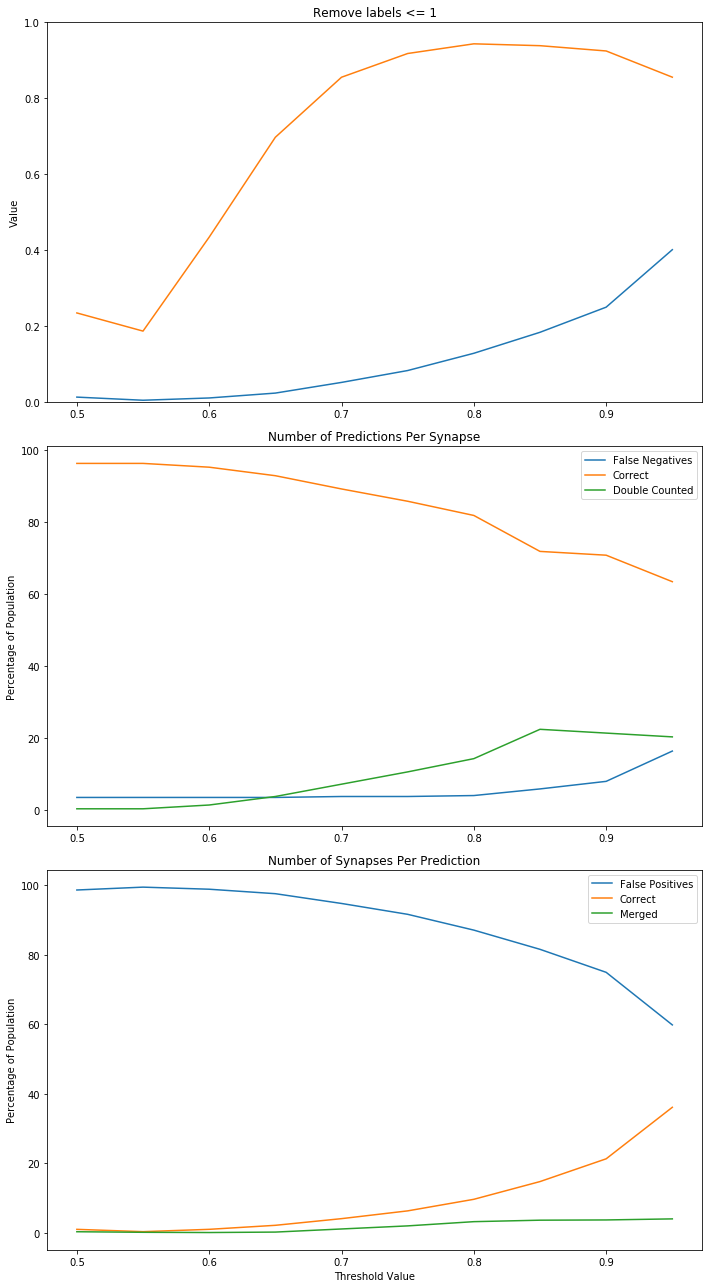

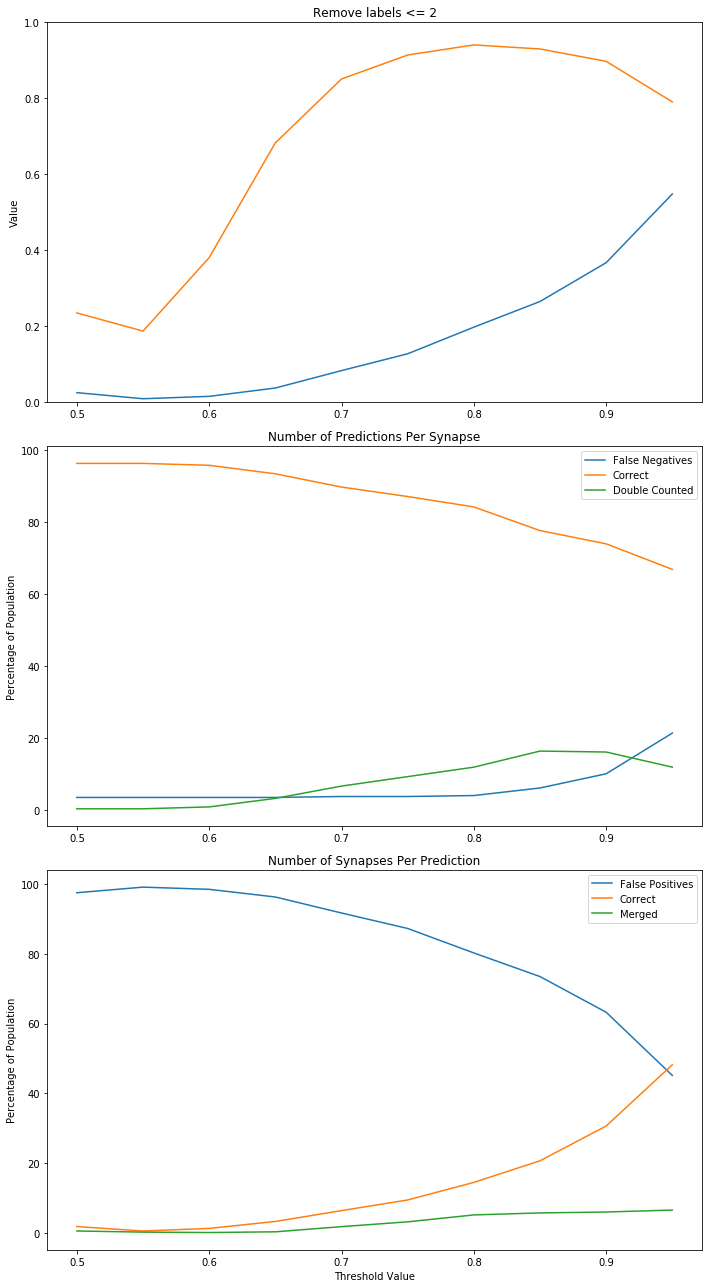

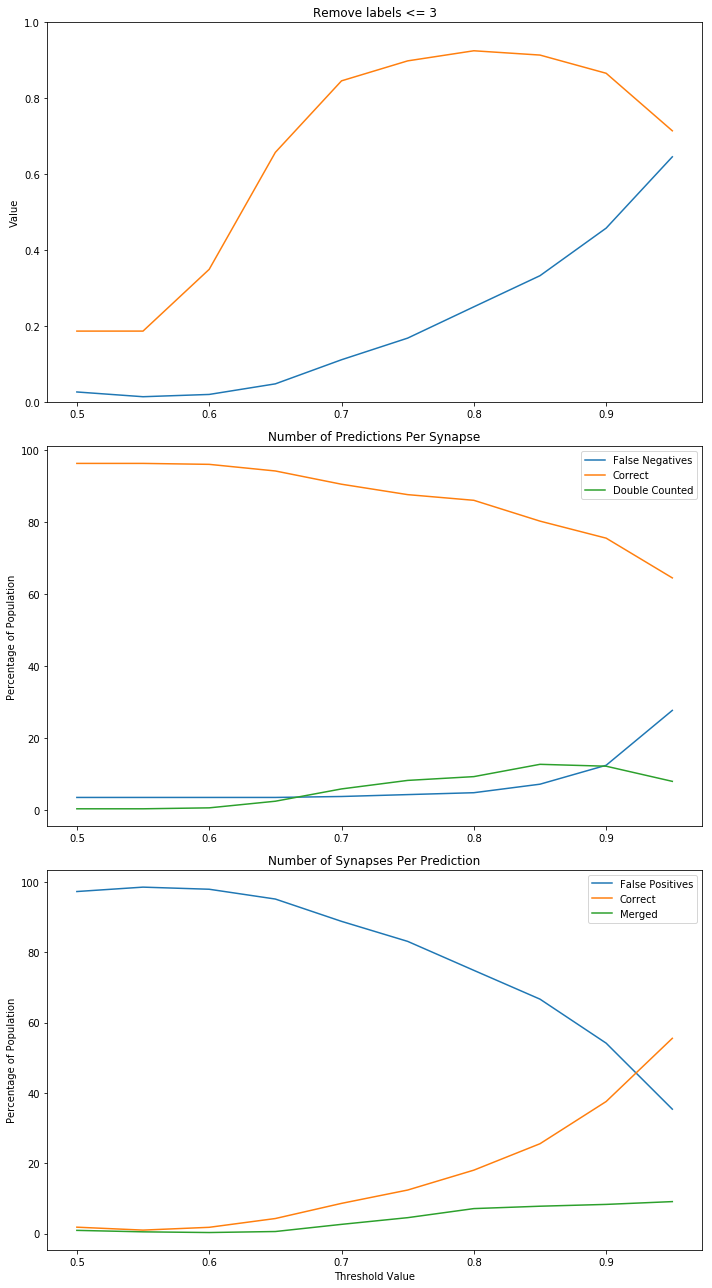

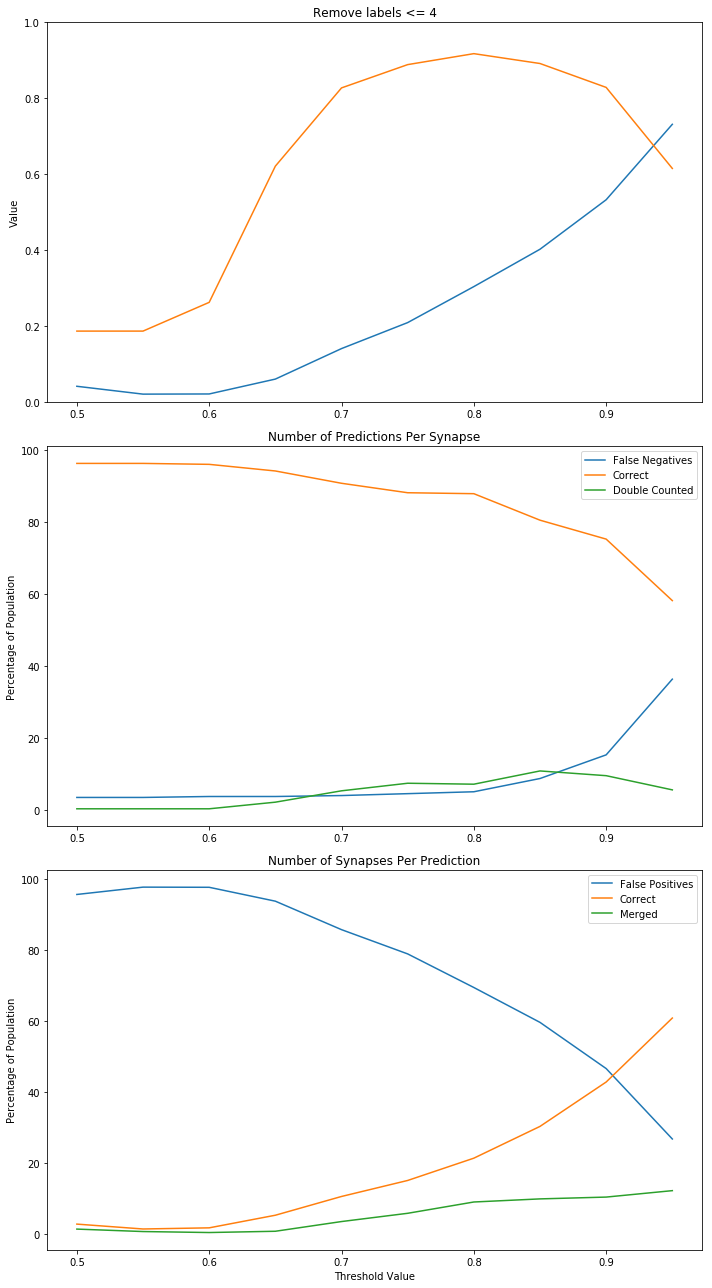

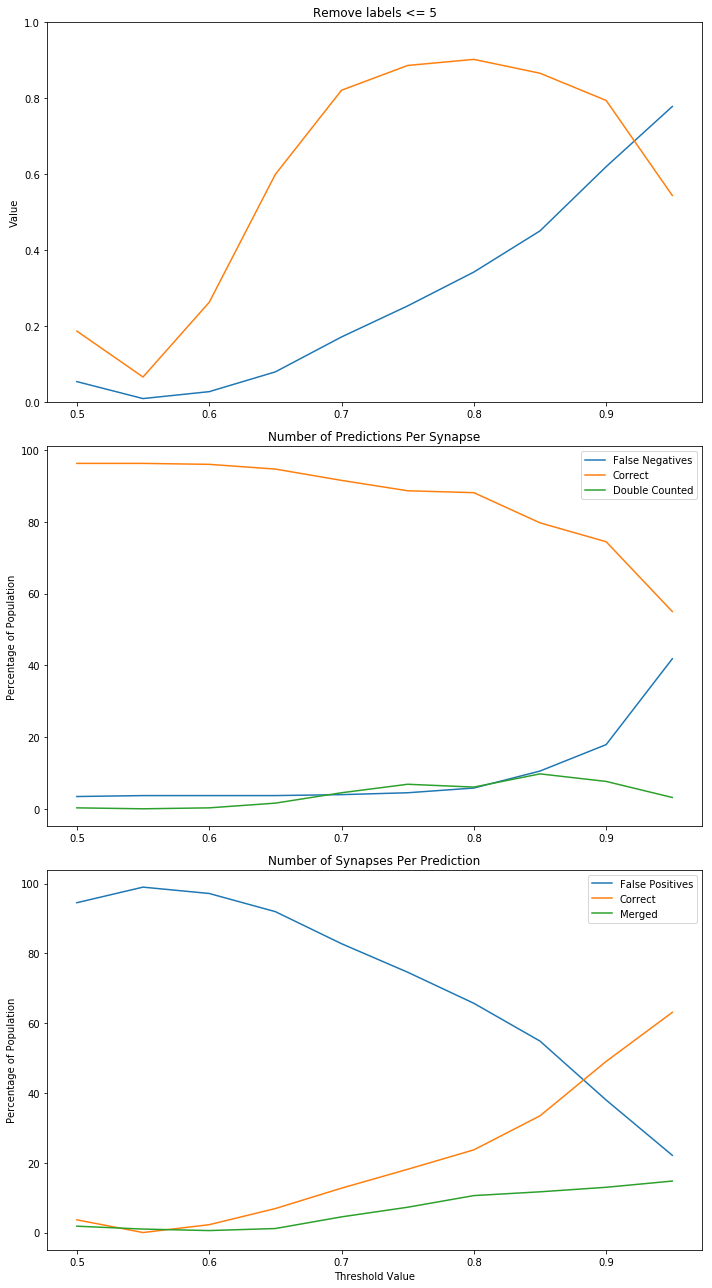

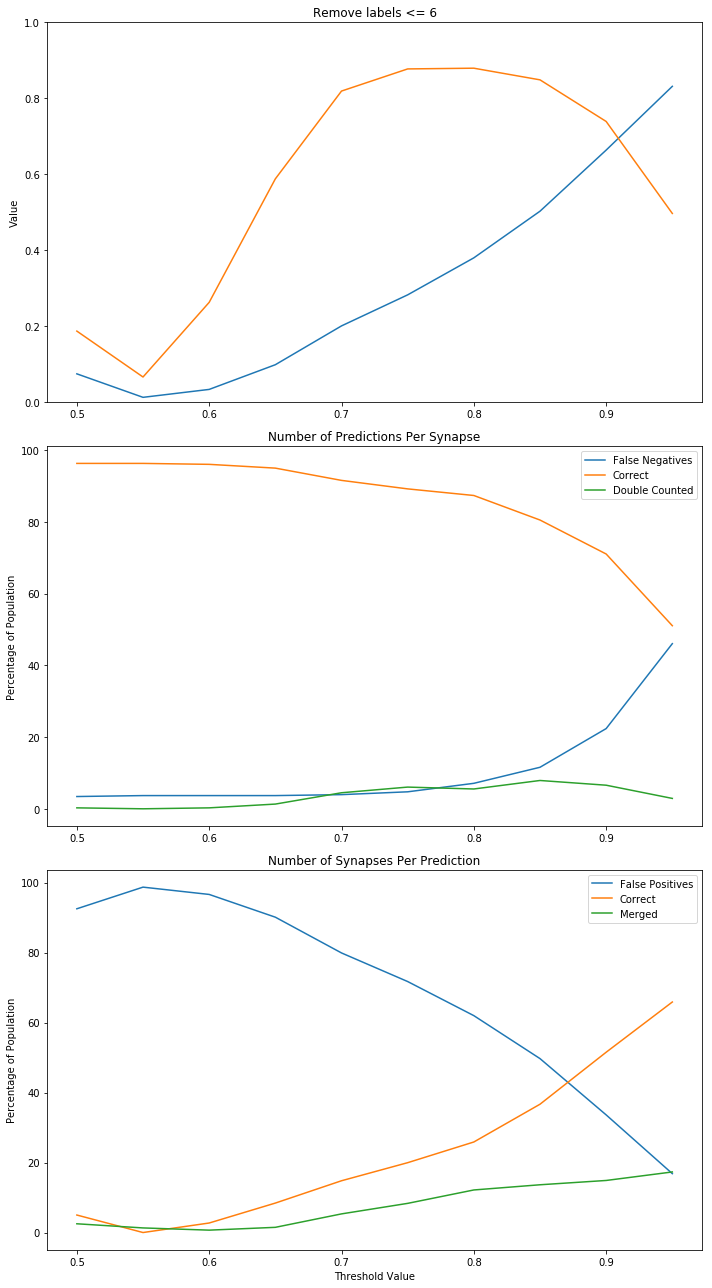

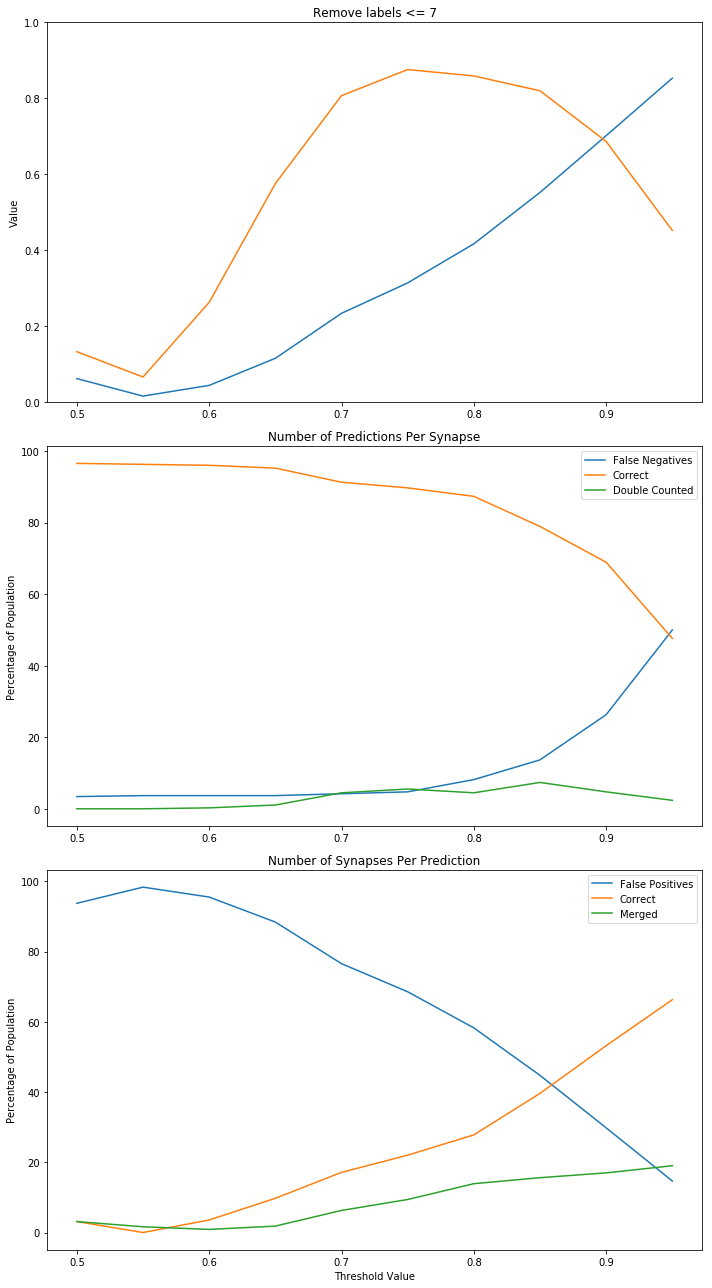

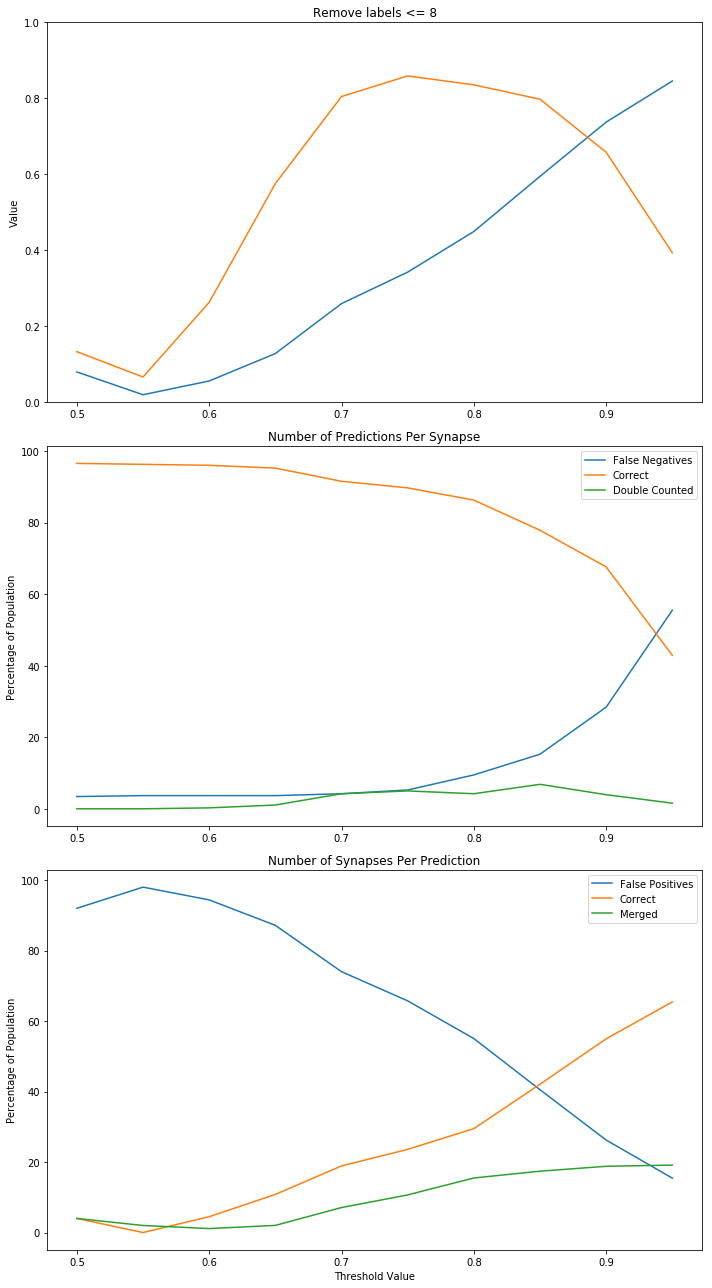

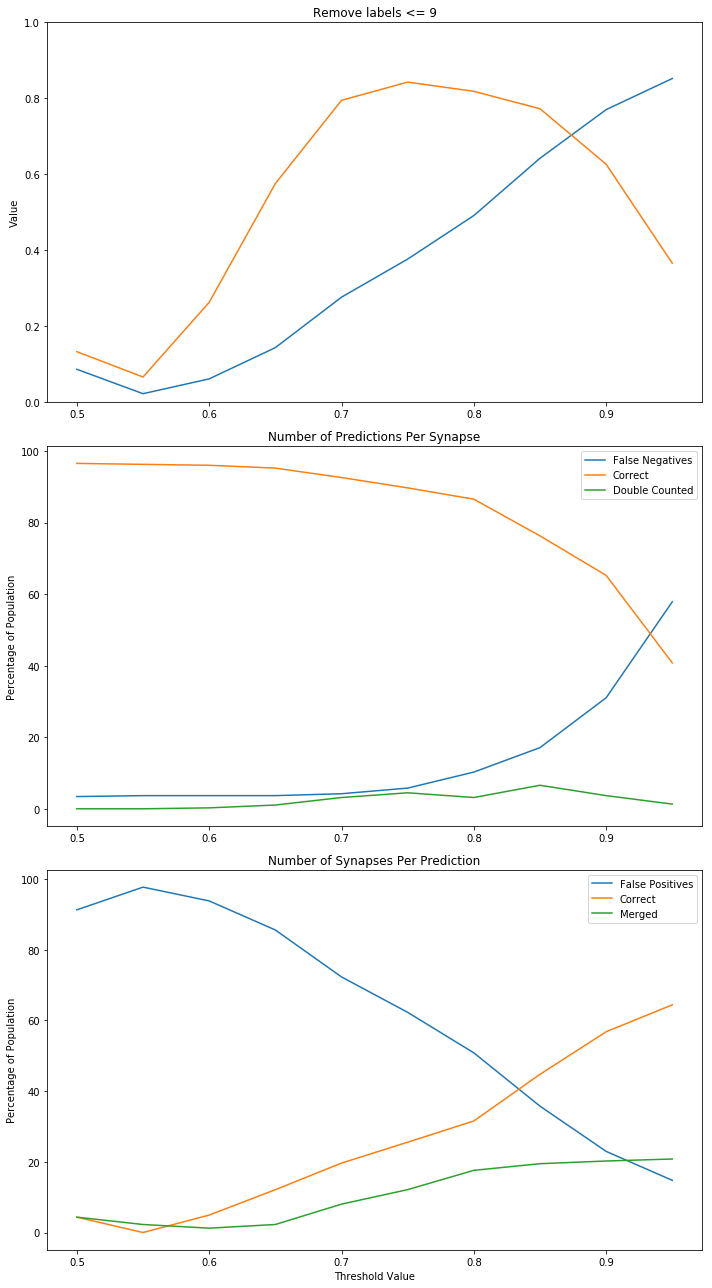

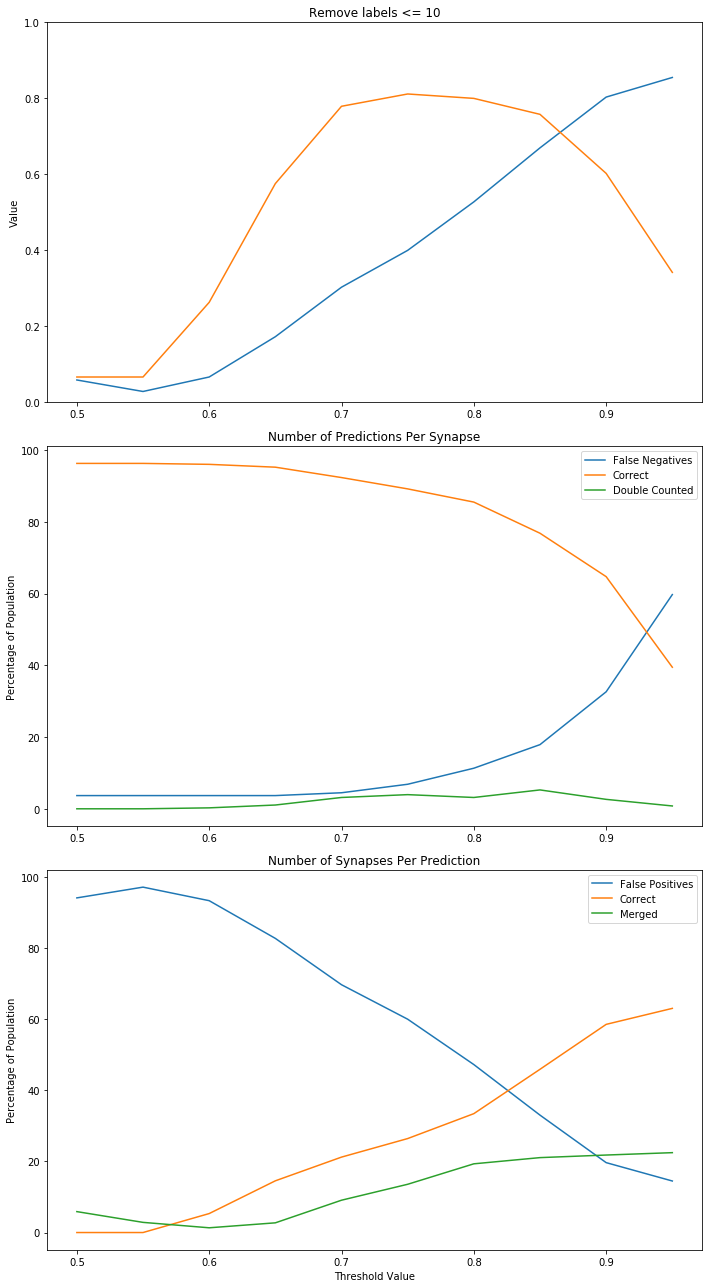

In [19]:
thresholds = np.arange(0.5, 1.0, 0.05)
min_sizes = range(1, 11, 1)
overlay_volumes = []

for min_size in min_sizes:
    overlaps = []
    
    for threshold in thresholds:
        labels = label(probmap_subsection >= threshold)
        labels = remove_labels(labels, min_size)
        overlaps.append(compute_overlap_array(labels, annotation_subsection))
        
    #display.display(plot_pres_recall(overlaps, thresholds, min_size))
    display.display(plot_graph_performance(overlaps, thresholds, min_size))

In [14]:
plt.close('all')